In [227]:
import pandas as pd
import pdb
import random
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, model_selection, r2_score
from sklearn.metrics import mean_squared_error, r2_score
from numpy.random import multinomial
rowCols = ['Percent Black', 'Percent White', 'Percent Asian', 'Percent Hispanic']
rankCols = [col + ' Ranking' for col in rowCols] 
neededCols = [rowCols[:1][0], 'Average Score (SAT Math)']
df = pd.read_csv('scores.csv')
zip_to_boro = pd.read_csv('zip_borough.csv')
boros = ['Manhattan', 'Staten', 'Bronx', 'Queens', 'Brooklyn']
df.shape
percent_spent_df = pd.read_csv('school_spend.csv')

In [228]:
percent_spent_df['Spent Per Student'] = pd.to_numeric(percent_spent_df['Spent Per Student'].str.replace('[^a-zA-Z0-9]', ''))

In [229]:
percent_spent_df.head()

,Unnamed: 0,School Name,Spent Per Student,Student enrollment,Amount needed to reach 100% Fair Student Funding,Percent of Fair Student Funding
0,0,47 The American Sign Language and English Seco...,29476,199,NaN,NaN
1,1,A. Philip Randolph Campus High School,20440,1365,"$1,514,887",90%
2,2,A.C.E. Academy for Scholars at the Geraldine F...,19736,523,$0,100%
3,3,Abraham Lincoln High School,20884,1840,"$2,127,340",90%
4,4,Abraham Lincoln YABC,12248,212,NaN,NaN


In [230]:
df = pd.merge(df, percent_spent_df, how='inner', on='School Name')
df['School Name'].nunique()

311

In [231]:
df.head()

,School ID,School Name,Borough,Building Code,Street Address,City,State,Zip Code,Latitude,Longitude,...,Percent Asian,Average Score (SAT Math),Average Score (SAT Reading),Average Score (SAT Writing),Percent Tested,Unnamed: 0,Spent Per Student,Student enrollment,Amount needed to reach 100% Fair Student Funding,Percent of Fair Student Funding
0,06M211,Inwood Early College for Health and Informatio...,Manhattan,M052,650 Academy Street,Manhattan,NY,10002,40.86605,-73.92486,...,4.60%,NaN,NaN,NaN,NaN,410,23922,415,$0,100%
1,01M539,"New Explorations into Science, Technology and ...",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,...,38.50%,657.0,601.0,601.0,91.00%,605,16571,1717,"$1,441,075",91%
2,02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,5.90%,395.0,411.0,387.0,78.90%,232,22838,327,"$327,809",92%
3,02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,8.60%,418.0,428.0,415.0,65.10%,504,25875,304,"$410,682",90%
4,02M545,High School for Dual Language and Asian Studies,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,88.90%,613.0,453.0,463.0,95.90%,297,19714,394,$0,112%


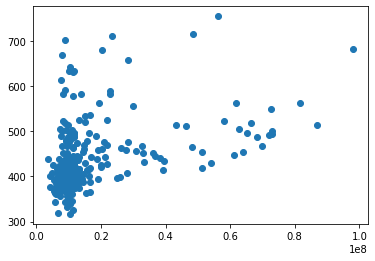

In [232]:
plt.scatter(df['Student enrollment'] * df['Spent Per Student'] , df['Average Score (SAT Math)'])

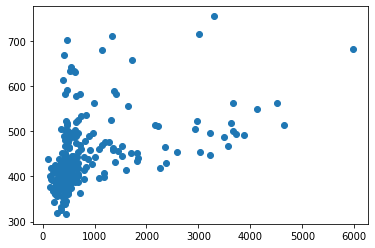

In [233]:
plt.scatter(df['Student enrollment'], df['Average Score (SAT Math)'])

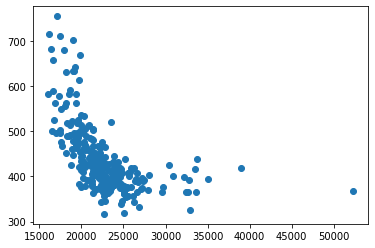

In [234]:
plt.scatter(df['Spent Per Student'], df['Average Score (SAT Math)'])

In [235]:
zip_to_boro.borough.unique()
boro_to_int = dict(zip(zip_to_boro.borough.unique(), [1,2,3,4,5]))
zip_to_boro['boro_id'] = zip_to_boro.borough.apply(lambda x: boro_to_int[x])
zip_to_boro = zip_to_boro.set_index('zip')
zip_to_boro.head(), boro_to_int


(         borough  boro_id
 zip                      
 10001  Manhattan        1
 10002  Manhattan        1
 10003  Manhattan        1
 10004  Manhattan        1
 10005  Manhattan        1,
 {'Manhattan': 1, 'Staten': 2, 'Bronx': 3, 'Queens': 4, 'Brooklyn': 5})

In [236]:
df['boro_id'] = df['Zip Code'].apply(lambda x: zip_to_boro.loc[x]['borough'])


In [237]:
for col in neededCols:
    df = df[pd.notnull(df[col])]
df.shape

(271, 28)

In [238]:
df = df.join(pd.get_dummies(df['boro_id']))

In [239]:
for col in rowCols:
    df[col] = pd.to_numeric(df[col].map(lambda pcnt: pcnt.strip('%')))

In [240]:
def getOther(row):
    return 100 - row[rowCols].sum()

df['Percent Other'] = df[rowCols].apply(getOther, axis=1)

In [241]:
df['variance'] = 1
df.columns

Index(['School ID', 'School Name', 'Borough', 'Building Code',
       'Street Address', 'City', 'State', 'Zip Code', 'Latitude', 'Longitude',
       'Phone Number', 'Start Time', 'End Time', 'Student Enrollment',
       'Percent White', 'Percent Black', 'Percent Hispanic', 'Percent Asian',
       'Average Score (SAT Math)', 'Average Score (SAT Reading)',
       'Average Score (SAT Writing)', 'Percent Tested', 'Unnamed: 0',
       'Spent Per Student', 'Student enrollment',
       'Amount needed to reach 100% Fair Student Funding',
       'Percent of Fair Student Funding', 'boro_id', 'Bronx', 'Brooklyn',
       'Manhattan', 'Queens', 'Staten', 'Percent Other', 'variance'],
      dtype='object')

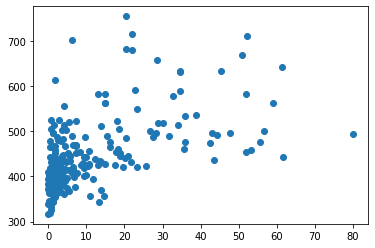

In [242]:
plt.scatter(df['Percent White'], df['Average Score (SAT Math)'])

In [243]:
df.head()

,School ID,School Name,Borough,Building Code,Street Address,City,State,Zip Code,Latitude,Longitude,...,Amount needed to reach 100% Fair Student Funding,Percent of Fair Student Funding,boro_id,Bronx,Brooklyn,Manhattan,Queens,Staten,Percent Other,variance
1,01M539,"New Explorations into Science, Technology and ...",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,...,"$1,441,075",91%,Manhattan,0,0,1,0,0,1.6,1
2,02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,"$327,809",92%,Manhattan,0,0,1,0,0,2.6,1
3,02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,"$410,682",90%,Manhattan,0,0,1,0,0,3.2,1
4,02M545,High School for Dual Language and Asian Studies,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,$0,112%,Manhattan,0,0,1,0,0,0.8,1
5,01M696,Bard High School Early College,Manhattan,M097,525 East Houston Street,Manhattan,NY,10002,40.71896,-73.97607,...,"$447,633",93%,Manhattan,0,0,1,0,0,1.7,1


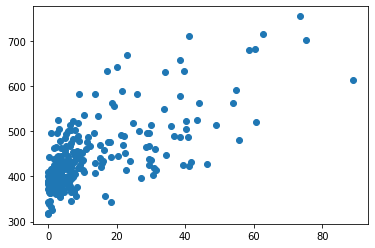

In [244]:
plt.scatter(df['Percent Asian'], df['Average Score (SAT Math)'])

In [245]:
# v_dict = {1.1: .9, 1.0: 1.0, .9: 1.1, .98: }
def randomizeDemos(row):
    try:
        variance = random.uniform(.90, 1.1)
        variance2 = 2 - variance
        new_demos = multinomial(100, row[rowCols + ['Percent Other']].values * 0.01)
        obj = dict(zip(rowCols + ['Percent Other'], new_demos))
        obj['Average Score (SAT Math)'] = row['Average Score (SAT Math)']  * variance
        obj['variance'] = variance
        obj['Spent Per Student'] = row['Spent Per Student'] * variance2
        obj["Student enrollment"] = row["Student enrollment"] * variance
        for b in boros:
            obj[b] = row[b]
    except:
        return
        
    return pd.Series(obj)

simulated_schools = pd.concat([df[rowCols + ['Percent Other', 'Average Score (SAT Math)', 'Spent Per Student', 'Student enrollment'] + boros].apply(randomizeDemos, axis=1) for _ in range(20)])
simulated_schools.head()

,Percent Black,Percent White,Percent Asian,Percent Hispanic,Percent Other,Average Score (SAT Math),variance,Spent Per Student,Student enrollment,Manhattan,Staten,Bronx,Queens,Brooklyn
1,13.0,30.0,38.0,18.0,1.0,654.200705,0.995739,16641.604451,1709.684338,1.0,0.0,0.0,0.0,0.0
2,45.0,11.0,4.0,38.0,2.0,396.710331,1.004330,22739.112539,328.415895,1.0,0.0,0.0,0.0,0.0
3,28.0,4.0,16.0,49.0,3.0,424.795180,1.016256,25454.365351,308.941949,1.0,0.0,0.0,0.0,0.0
4,5.0,1.0,86.0,6.0,2.0,647.949805,1.057014,18590.018829,416.463659,1.0,0.0,0.0,0.0,0.0
5,14.0,43.0,22.0,18.0,3.0,691.922347,1.091360,17418.625571,663.546982,1.0,0.0,0.0,0.0,0.0


In [246]:
simulated_schools = simulated_schools.dropna()

In [247]:
df[rowCols + ['Percent Other', 'Average Score (SAT Math)'] + boros + ['variance', 'Spent Per Student']].head()

,Percent Black,Percent White,Percent Asian,Percent Hispanic,Percent Other,Average Score (SAT Math),Manhattan,Staten,Bronx,Queens,Brooklyn,variance,Spent Per Student
1,13.3,28.6,38.5,18.0,1.6,657.0,1,0,0,0,0,1,16571
2,38.5,11.7,5.9,41.3,2.6,395.0,1,0,0,0,0,1,22838
3,28.2,3.1,8.6,56.9,3.2,418.0,1,0,0,0,0,1,25875
4,3.1,1.7,88.9,5.5,0.8,613.0,1,0,0,0,0,1,19714
5,17.2,45.3,17.1,18.7,1.7,634.0,1,0,0,0,0,1,19170


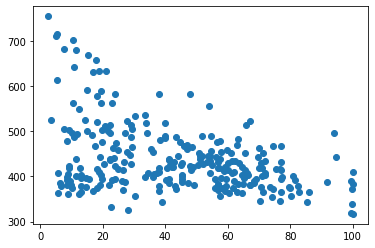

In [248]:
plt.scatter(df['Percent Hispanic'], df['Average Score (SAT Math)'])

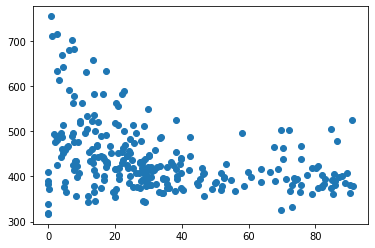

In [249]:
plt.scatter(df['Percent Black'], df['Average Score (SAT Math)'])

In [250]:
sim_and_real_data = pd.concat([simulated_schools[rowCols + ['Percent Other'] + boros + ['Average Score (SAT Math)', 'variance', 'Spent Per Student', "Student enrollment"]], df[rowCols + ['Percent Other'] + boros + ['Average Score (SAT Math)', 'variance', 'Spent Per Student', "Student enrollment"]]])
sim_and_real_data = sim_and_real_data.dropna()
sim_and_real_data.head()

,Percent Black,Percent White,Percent Asian,Percent Hispanic,Percent Other,Manhattan,Staten,Bronx,Queens,Brooklyn,Average Score (SAT Math),variance,Spent Per Student,Student enrollment
1,13.0,30.0,38.0,18.0,1.0,1.0,0.0,0.0,0.0,0.0,654.200705,0.995739,16641.604451,1709.684338
2,45.0,11.0,4.0,38.0,2.0,1.0,0.0,0.0,0.0,0.0,396.710331,1.004330,22739.112539,328.415895
3,28.0,4.0,16.0,49.0,3.0,1.0,0.0,0.0,0.0,0.0,424.795180,1.016256,25454.365351,308.941949
4,5.0,1.0,86.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,647.949805,1.057014,18590.018829,416.463659
5,14.0,43.0,22.0,18.0,3.0,1.0,0.0,0.0,0.0,0.0,691.922347,1.091360,17418.625571,663.546982


In [286]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(sim_and_real_data[rowCols + ['Percent Other', 'variance', 'Spent Per Student', "Student enrollment"] + boros], sim_and_real_data['Average Score (SAT Math)'])


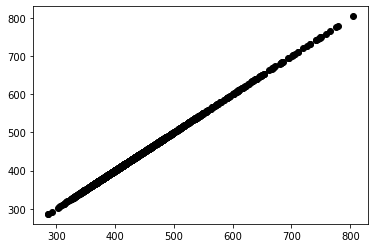

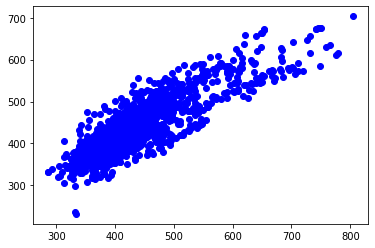

In [350]:
# create a linear regression object
regr = linear_model.LinearRegression()

# train the model using the training sets
regr.fit(x_train, y_train)

# make predicitons using the testing set
y_predictions = regr.predict(x_test)

plt.scatter(y_test, y_test, color="black")
plt.xticks()
plt.yticks()

plt.show()

plt.scatter(y_test, y_predictions, color="blue")
plt.show()

In [288]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print("Mean squared error: %.2f"
     % mean_squared_error(y_test, y_predictions))

# Explained variance score: 1 is the perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_predictions))

# Explained r2 score: 1 is the best possible fit
print('R^2 score: %.2f' % r2_score(y_test, y_predictions))


Coefficients: 
 [-1.01842290e+00  4.68773662e-01  1.21285905e+00 -1.46917764e+00
  8.05967838e-01  3.58387425e+02 -3.80715266e-03  7.08908188e-03
  2.82277753e+01 -2.10198191e+01  1.37613330e+01 -1.19703170e+01
 -8.99897226e+00]
Mean squared error: 1758.91
Variance score: 0.73
R^2 score: 0.73


In [271]:
df[rowCols + ['Student enrollment','Percent Other', 'Spent Per Student', 'Average Score (SAT Math)'] + boros].corr()

,Percent Black,Percent White,Percent Asian,Percent Hispanic,Student enrollment,Percent Other,Spent Per Student,Average Score (SAT Math),Manhattan,Staten,Bronx,Queens,Brooklyn
Percent Black,1.000000,-0.419497,-0.418917,-0.523638,-0.297770,0.049119,0.317483,-0.367400,-0.194882,-0.123807,-0.116275,-0.154140,0.479170
Percent White,-0.419497,1.000000,0.312050,-0.355792,0.392525,0.207088,-0.391038,0.569818,0.039715,0.461828,-0.243583,0.061415,-0.047545
Percent Asian,-0.418917,0.312050,1.000000,-0.382510,0.496021,0.081449,-0.414802,0.707551,-0.000960,-0.007762,-0.253998,0.403048,-0.114633
Percent Hispanic,-0.523638,-0.355792,-0.382510,1.000000,-0.232807,-0.284954,0.175014,-0.411912,0.166327,-0.133279,0.427055,-0.136176,-0.384031
Student enrollment,-0.297770,0.392525,0.496021,-0.232807,1.000000,0.011284,-0.391644,0.473534,-0.115148,0.225426,-0.201979,0.209869,0.023785
Percent Other,0.049119,0.207088,0.081449,-0.284954,0.011284,1.000000,-0.232386,0.255183,0.173579,-0.022069,-0.127289,0.096289,-0.122855
Spent Per Student,0.317483,-0.391038,-0.414802,0.175014,-0.391644,-0.232386,1.000000,-0.564185,-0.145681,-0.070131,0.173713,-0.220435,0.198979
Average Score (SAT Math),-0.367400,0.569818,0.707551,-0.411912,0.473534,0.255183,-0.564185,1.000000,0.190243,0.117555,-0.245383,0.187392,-0.164189
Manhattan,-0.194882,0.039715,-0.000960,0.166327,-0.115148,0.173579,-0.145681,0.190243,1.000000,-0.106217,-0.315399,-0.285884,-0.364327
Staten,-0.123807,0.461828,-0.007762,-0.133279,0.225426,-0.022069,-0.070131,0.117555,-0.106217,1.000000,-0.102002,-0.092457,-0.117825


In [328]:
ma_scores = pd.read_csv('ma_scores.csv')
ma_scores = ma_scores[['Average SAT_Math', '% African American', '% Asian', '% Hispanic', '% White', '% Economically Disadvantaged']]
ma_scores.columns = ['Average Score (SAT Math)', 'Percent Black', 'Percent Asian', 'Percent Hispanic', 'Percent White', 'Percent Economically Disadvantaged']
for col in neededCols:
    ma_scores = ma_scores[pd.notnull(ma_scores[col])]
ma_scores['Percent Other'] = ma_scores[rowCols].apply(getOther, axis=1)
ma_scores.head()

,Average Score (SAT Math),Percent Black,Percent Asian,Percent Hispanic,Percent White,Percent Economically Disadvantaged,Percent Other
0,516.0,2.2,1.5,9.1,85.8,21.5,1.4
8,514.0,1.2,2.2,5.8,88.8,22.7,2.0
16,534.0,1.3,1.2,4.2,90.7,14.6,2.6
23,581.0,1.9,14.5,5.0,76.3,6.3,2.3
33,592.0,4.1,10.7,5.7,75.6,10.3,3.9


In [334]:
x_train2, x_test2, y_train2, y_test2 = model_selection.train_test_split(ma_scores[rowCols + ['Percent Other', 'Percent Economically Disadvantaged']], ma_scores['Average Score (SAT Math)'])

In [352]:
regr2 = linear_model.LinearRegression()


regr2.fit(x_train2, y_train2)

# make predicitons using the testing set
y_predictions2 = regr2.predict(x_test2)

In [353]:
print('R^2 score: %.2f' % r2_score(y_test2, y_predictions2))

R^2 score: 0.72


In [337]:
ma_scores.corr()

,Average Score (SAT Math),Percent Black,Percent Asian,Percent Hispanic,Percent White,Percent Economically Disadvantaged,Percent Other
Average Score (SAT Math),1.000000,-0.528775,0.321631,-0.664958,0.616714,-0.834383,0.118645
Percent Black,-0.528775,1.000000,0.042982,0.389820,-0.782805,0.595247,0.021618
Percent Asian,0.321631,0.042982,1.000000,-0.022104,-0.255989,-0.055867,0.100749
Percent Hispanic,-0.664958,0.389820,-0.022104,1.000000,-0.828667,0.797523,-0.159899
Percent White,0.616714,-0.782805,-0.255989,-0.828667,1.000000,-0.806780,0.009381
Percent Economically Disadvantaged,-0.834383,0.595247,-0.055867,0.797523,-0.806780,1.000000,-0.009092
Percent Other,0.118645,0.021618,0.100749,-0.159899,0.009381,-0.009092,1.000000


In [354]:
import pickle
regr = regr
pickle.dump(regr, open('primary_sat_model.sav', 'wb'))

In [355]:
result = pickle.load(open('primary_sat_model.sav', 'rb'))

In [360]:
# result.predict(x_test)
list(x_test.columns)

['Percent Black',
 'Percent White',
 'Percent Asian',
 'Percent Hispanic',
 'Percent Other',
 'variance',
 'Spent Per Student',
 'Student enrollment',
 'Manhattan',
 'Staten',
 'Bronx',
 'Queens',
 'Brooklyn']